## Initialisation

In [2]:
import os

import numpy as np # type: ignore
import pandas as pd # type: ignore

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find('project')
# slice the path from the index of 'project' to the end
project_path = path[:index_project+7]
# set the working directory
os.chdir(project_path)
print(f'Project path set to: {os.getcwd()}')

Project path set to: c:\Github\ode-biomarker-project


In [3]:
# Bring in CCLE data
from PathLoader import PathLoader
from DataLink import DataLink
path_loader = PathLoader('data_config.env', 'current_user.env')
data_link = DataLink(path_loader, 'data_codes.csv')

In [4]:
core_used = 32
normalised = True
save_model = True
fixed_random_seed = 42  # -1 for no seed, NOT IN USE
save_figure = False
save_data = True
show_figure = False
rngs = list(range(100)) # for stable rng, for pure random, a random set can be used

In [5]:
# dynamic_data_code = 'fgfr4_ccle_dynamic_features_v2'
# drug_code = 'gdsc-1-FGFR_0939'
# match_rules_data_code = 'fgfr4_model_ccle_match_rules'
# folder_name = "FGFR4-combined-model-training"
# exp_id = "fgfr4_v4"  # experiment id, fgfr4_v1, cdk46_v1

In [61]:
dynamic_data_code = 'cdk46_ccle_dynamic_features_v3'
drug_code = 'gdsc-2-Palbociclib'
match_rules_data_code = 'cdk_model_match_rules'
folder_name = "AN19"
exp_id = "cdk46_t1" # experiment id, fgfr4_v1, cdk46_v1

In [7]:
# load in dynamic features data 
loading_code = f'generic-{drug_code}-LN_IC50-{dynamic_data_code}-true-Unnamed: 0'
# generic-gdsc-{number}-{drug_name}-{target_label}-{dataset_name}-{replace_index}-{row_index}
dynamic_feature_data, dynamic_label_data = data_link.get_data_using_code(loading_code)
print(f'Data loaded for code {loading_code} Feature Shape {dynamic_feature_data.shape} Label Shape {dynamic_label_data.shape}')

# load in ccle static gene expression data
loading_code = f'ccle-{drug_code}-LN_IC50'
feature_data, label_data = data_link.get_data_using_code(loading_code)
print(f'Data loaded for code {loading_code} Feature Shape {feature_data.shape} Label Shape {label_data.shape}')

match_rules = data_link.get_data_from_code(match_rules_data_code)

Data loaded for code generic-gdsc-2-Palbociclib-LN_IC50-cdk46_ccle_dynamic_features_v3-true-Unnamed: 0 Feature Shape (584, 590) Label Shape (584,)
Data loaded for code ccle-gdsc-2-Palbociclib-LN_IC50 Feature Shape (584, 19221) Label Shape (584,)


In [8]:
from toolkit import *

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [63]:
all_models = ['RandomForestRegressor', 'XGBRegressor']

if not os.path.exists(f'{path_loader.get_data_path()}data/results/{folder_name}'):
    os.makedirs(f'{path_loader.get_data_path()}data/results/{folder_name}')

file_save_path = f'{path_loader.get_data_path()}data/results/{folder_name}/'

In [10]:
# remove samples present in feature data but not in dynamic feature data
new_feature_data = feature_data.loc[feature_data.index.isin(dynamic_feature_data.index)]
new_label_data = label_data.loc[label_data.index.isin(dynamic_feature_data.index)]

# check size 
print(new_feature_data.shape)
print(new_label_data.shape)

(584, 19221)
(584,)


In [11]:
combined_feature_data = pd.concat([new_feature_data, dynamic_feature_data], axis=1)
combined_label_data = new_label_data

In [12]:
def normalise_data(data): 
    data = (data - data.mean()) / data.std()
    return data

def pipeline_func(X_train, y_train, rng, model_used, normalised=False, **kwargs):
    # impute missing values by first quantile first 
    # normalise X_train 
    if normalised:
        X_train = normalise_data(X_train)
    X_train, _ = impute_by_first_quantile(X_train, y_train)
    k = X_train.shape[1]
    if k > 500: 
        k = 500 # limit the number of features to 500
    selected_features, scores = f_regression_select(X_train, y_train, k)
    model = get_model_from_string(model_used, **kwargs)
    selected_features, X_selected = select_preset_features(X_train, y_train, selected_features)
    # print(f'{rng} {model_used}')
    model.fit(X_selected, y_train)
    return {'model': model,
            'filter_selected_features': selected_features,
            'filter_scores': scores}
    
def eval_func(X_test, y_test, pipeline_components=None, 
              normalised=False,
              save_model=False, 
              **kwargs):
    if normalised:
        X_test = (X_test - X_test.mean()) / X_test.std()
    X_test, _ = impute_by_first_quantile(X_test, y_test)
    selected_features, X_selected = select_preset_features(X_test, y_test, pipeline_components['filter_selected_features'])
    y_pred = pipeline_components['model'].predict(X_selected)
    # assess performance by pearson correlation
    corr, p_vals = pearsonr(y_test, y_pred)
    feat_imp = (pipeline_components['filter_selected_features'], pipeline_components['filter_scores'])
    returned_data = {'model_performance': corr, 'p_vals': p_vals, 'feature_importance': feat_imp}
    if save_model:
        returned_data['model'] = pipeline_components['model']
    return returned_data

def eval_func_best(X_test, y_test, pipeline_components=None, normalised=False, **kwargs):
    if normalised:
        X_test = (X_test - X_test.mean()) / X_test.std()
    X_test, _ = impute_by_first_quantile(X_test, y_test)
    selected_features, X_selected = select_preset_features(X_test, y_test, pipeline_components['filter_selected_features'])
    y_pred = pipeline_components['model'].predict(X_selected)
    # assess performance by pearson correlation
    corr, p_vals = pearsonr(y_test, y_pred)
    feat_imp = (pipeline_components['filter_selected_features'], pipeline_components['filter_scores'])
    return {'model_performance': corr, 'p_vals': p_vals, 'feature_importance': feat_imp, 'y_test': y_test, 'y_pred': y_pred}

### Visualisation between feature and label data by association

Calculated correlation values
Plotting


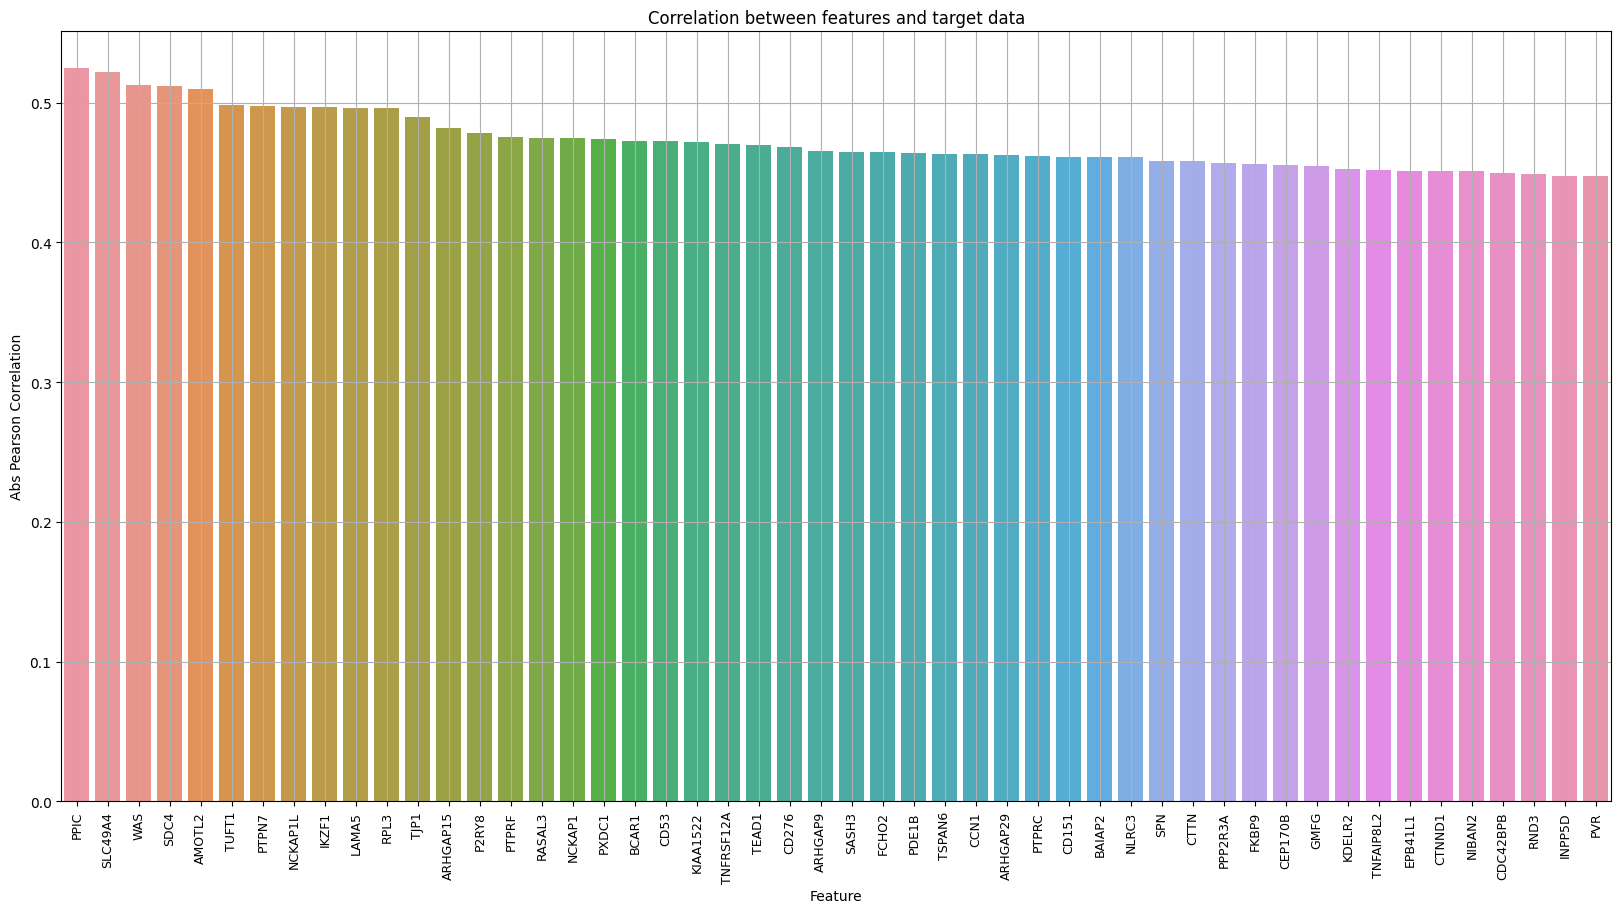

In [ ]:
# plot the association between the features and the target data in a bar chart based on the correlation values 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# create a dataframe with the feature data and target data
feature_data_df = pd.DataFrame(feature_data)
target_data_df = pd.DataFrame(label_data)
# add the target data to the feature data
feature_data_df['target'] = target_data_df

# calculate the correlation between the features and the target data
correlation = feature_data_df.corr()['target'].sort_values(ascending=False)
print('Calculated correlation values')
# create a dataframe with the correlation values
correlation_df = pd.DataFrame(correlation)
correlation_df = correlation_df.reset_index()
correlation_df.columns = ['feature', 'correlation']
# do not include the target data in the correlation dataframe
correlation_df = correlation_df[correlation_df['feature'] != 'target']
abs_correlation_df = correlation_df.copy()
# take the absolute value of the correlation
abs_correlation_df['correlation'] = abs(abs_correlation_df['correlation'])
# sort the dataframe by the absolute value of the correlation
abs_correlation_df = abs_correlation_df.sort_values(by='correlation', ascending=False)
# keep only the top 50 features
abs_correlation_df_50 = abs_correlation_df.head(50)


Plotting


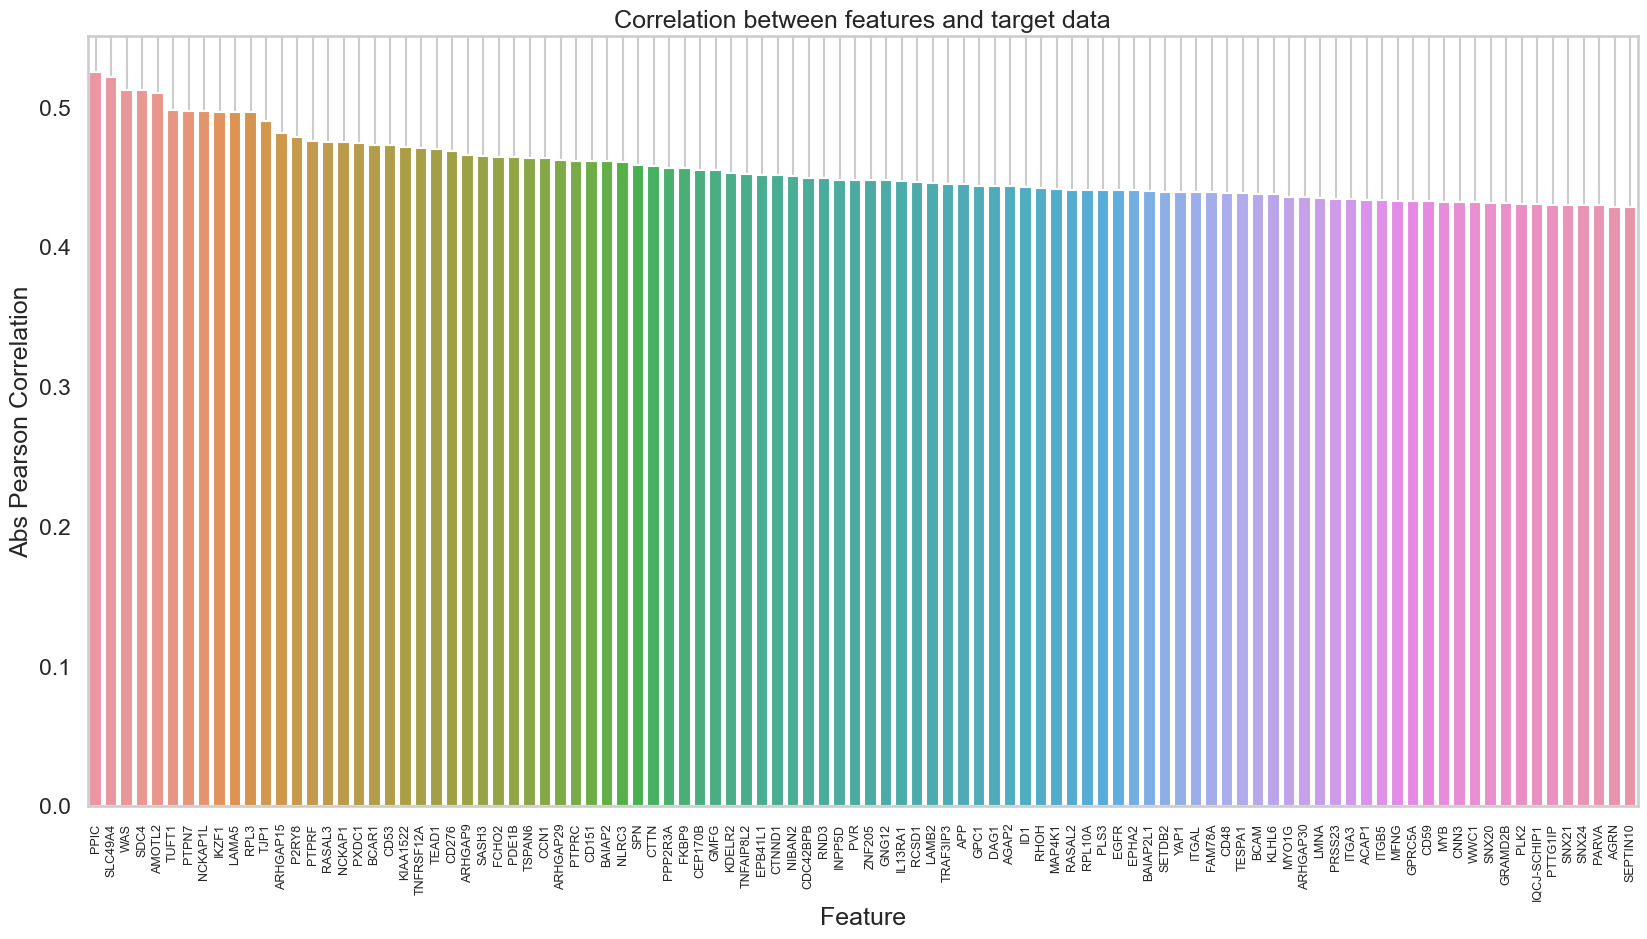

In [31]:
abs_correlation_df_100 = abs_correlation_df.head(100)
sns.set_context("talk")
sns.set_style("whitegrid")
print('Plotting')
# plot the correlation values
plt.figure(figsize=(20, 10))
sns.barplot(x='feature', y='correlation', data=abs_correlation_df_100)
plt.title('Correlation between features and target data')
plt.xlabel('Feature')
plt.ylabel('Abs Pearson Correlation')
plt.xticks(rotation=90, fontsize=9)
plt.grid()
plt.show()

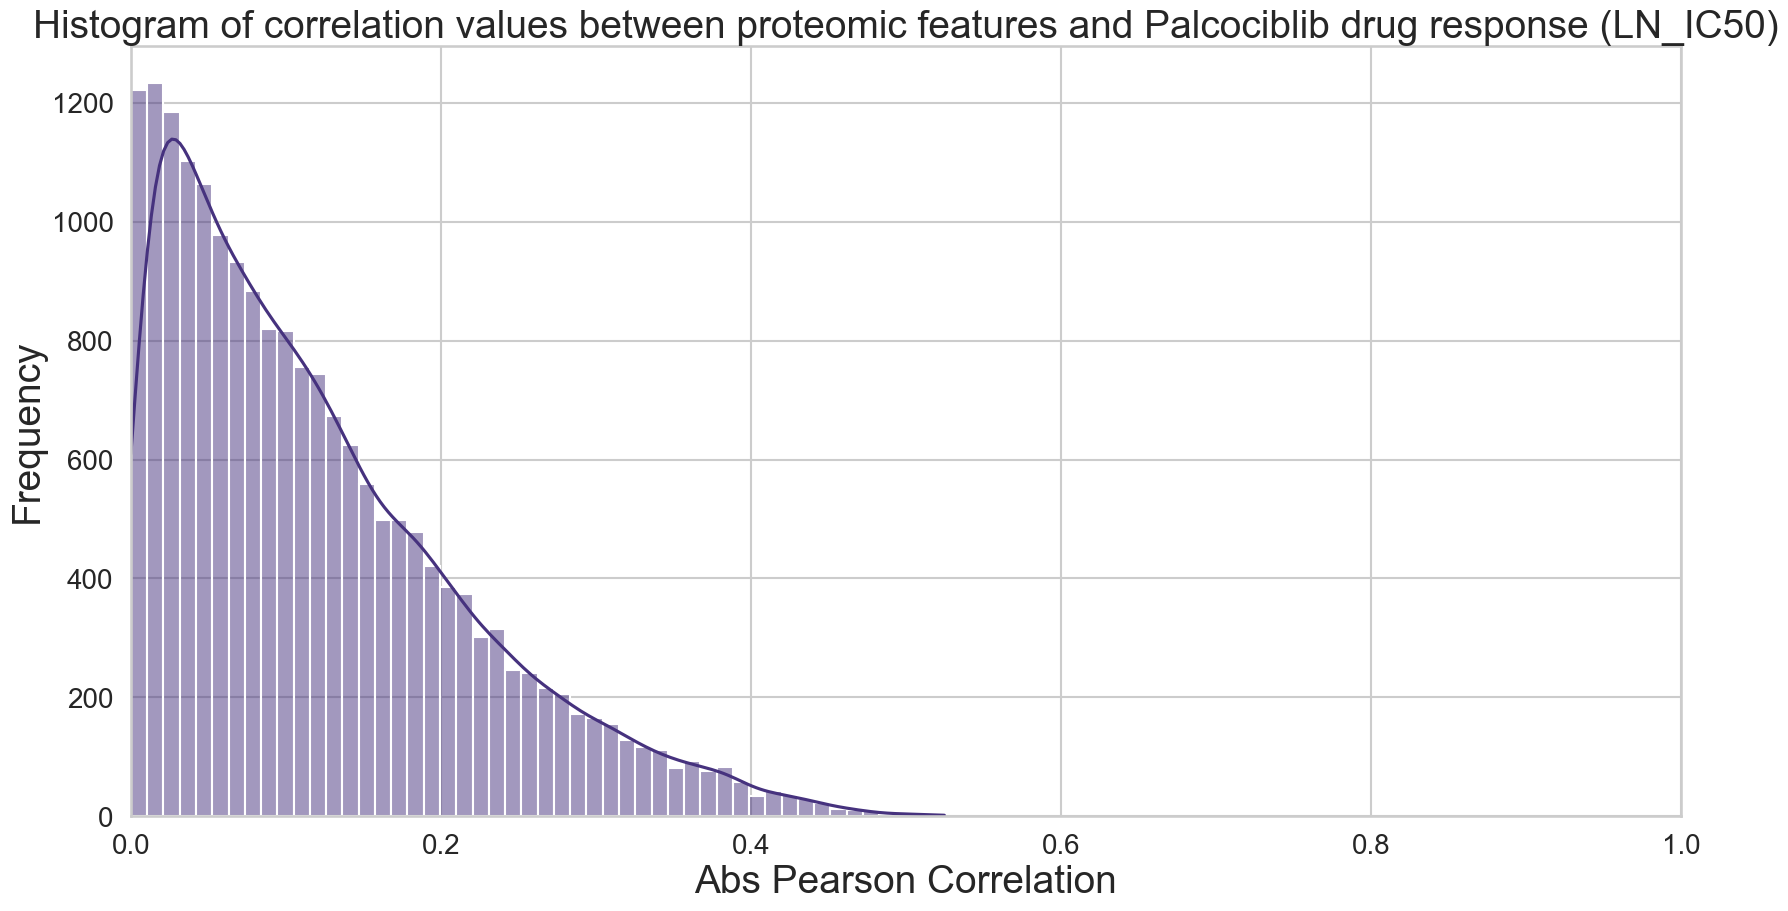

In [38]:

plt.figure(figsize=(20, 10))
sns.histplot(abs_correlation_df['correlation'], bins=50, kde=True)
plt.title('Histogram of correlation values between proteomic features and Palcociblib drug response (LN_IC50)', fontsize=28)
plt.xlabel('Abs Pearson Correlation', fontsize=28)
plt.ylabel('Frequency', fontsize=28)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(0,1)
plt.show()

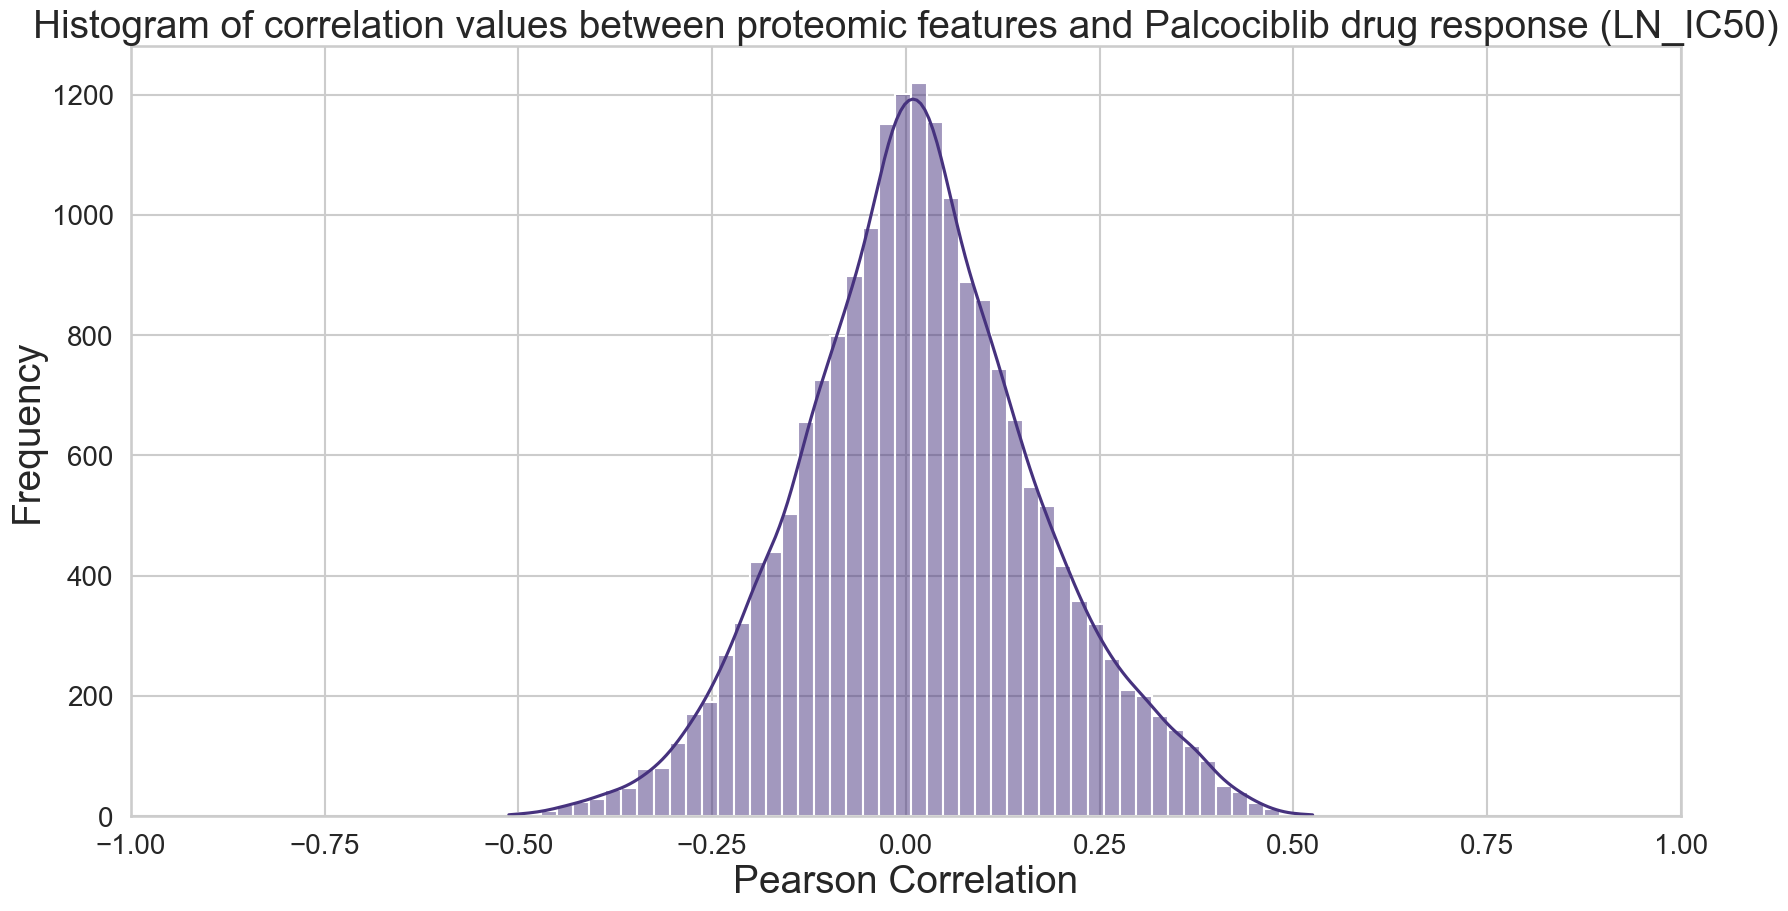

In [42]:
plt.figure(figsize=(20, 10))
sns.histplot(correlation_df['correlation'], bins=50, kde=True)
plt.title('Histogram of correlation values between proteomic features and Palcociblib drug response (LN_IC50)', fontsize=28)
plt.xlabel('Pearson Correlation', fontsize=28)
plt.ylabel('Frequency', fontsize=28)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(-1,1)
plt.show()

In [48]:
# calculate a probability density function for the correlation values
import numpy as np

# extract the mean and standard deviation of the correlation values
mean = np.mean(correlation_df['correlation'])
std = np.std(correlation_df['correlation'])
max_val = np.max(correlation_df['correlation'])
min_val = np.min(correlation_df['correlation'])
outliers = correlation_df[(correlation_df['correlation'] > mean + 3*std) | (correlation_df['correlation'] < mean - 3*std)]

print(f'Mean: {mean:.4f}')
print(f'Standard Deviation: {std:.4f}')
print(f'Max: {max_val:.4f}')
print(f'Min: {min_val:.4f}')
print(f'Outliers as a ratio of all features: {outliers.shape[0] / correlation_df.shape[0]:.4f}')




Mean: 0.0174
Standard Deviation: 0.1527
Max: 0.5248
Min: -0.5123
Outliers as a ratio of all features: 0.0017


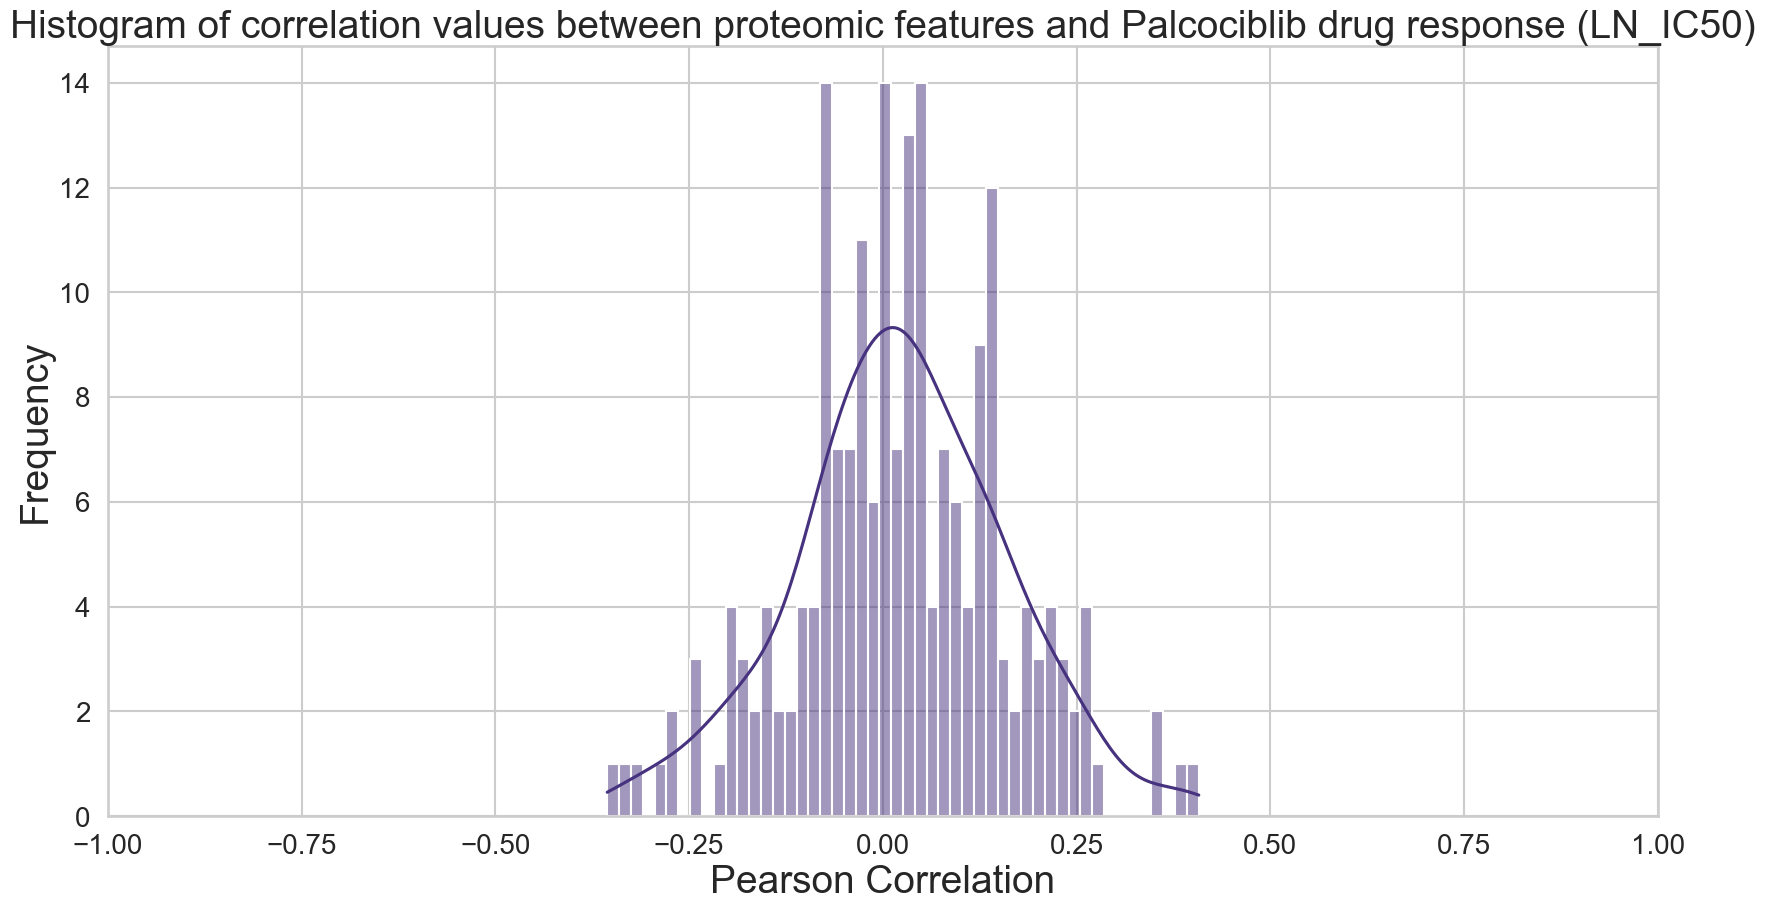

In [58]:
# randomly sample correlation df 

# sample 100 features from the correlation df
sampled_features = correlation_df.sample(n=200, random_state=42)
# plot the sampled features as a histogram
plt.figure(figsize=(20, 10))
sns.histplot(sampled_features['correlation'], bins=50, kde=True)
plt.title('Histogram of correlation values between proteomic features and Palcociblib drug response (LN_IC50)', fontsize=28)
plt.xlabel('Pearson Correlation', fontsize=28)
plt.ylabel('Frequency', fontsize=28)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(-1,1)
plt.show()

In [59]:
# calculate a probability density function for the correlation values
import numpy as np

# extract the mean and standard deviation of the correlation values
mean = np.mean(sampled_features['correlation'])
std = np.std(sampled_features['correlation'])
max_val = np.max(sampled_features['correlation'])
min_val = np.min(sampled_features['correlation'])
outliers = sampled_features[(sampled_features['correlation'] > mean + 3*std) | (sampled_features['correlation'] < mean - 3*std)]

print(f'Mean: {mean:.4f}')
print(f'Standard Deviation: {std:.4f}')
print(f'Max: {max_val:.4f}')
print(f'Min: {min_val:.4f}')
print(f'Outliers as a ratio of all features: {outliers.shape[0] / sampled_features.shape[0]:.4f}')




Mean: 0.0227
Standard Deviation: 0.1367
Max: 0.4077
Min: -0.3556
Outliers as a ratio of all features: 0.0000


In [64]:
# save the correlation values to a pickle file
import pickle
with open(f'{path_loader.get_data_path()}data/results/{folder_name}/correlation_values.pkl', 'wb') as f:
    pickle.dump(correlation_df, f)
print(f'Saved correlation values to {path_loader.get_data_path()}data/results/{folder_name}/correlation_values.pkl')

Saved correlation values to I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data/results/AN19/correlation_values.pkl
